# Loading necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

# Loading and preprocessing images

Index(['emotion', ' Usage', ' pixels', 'emotion_name'], dtype='object')


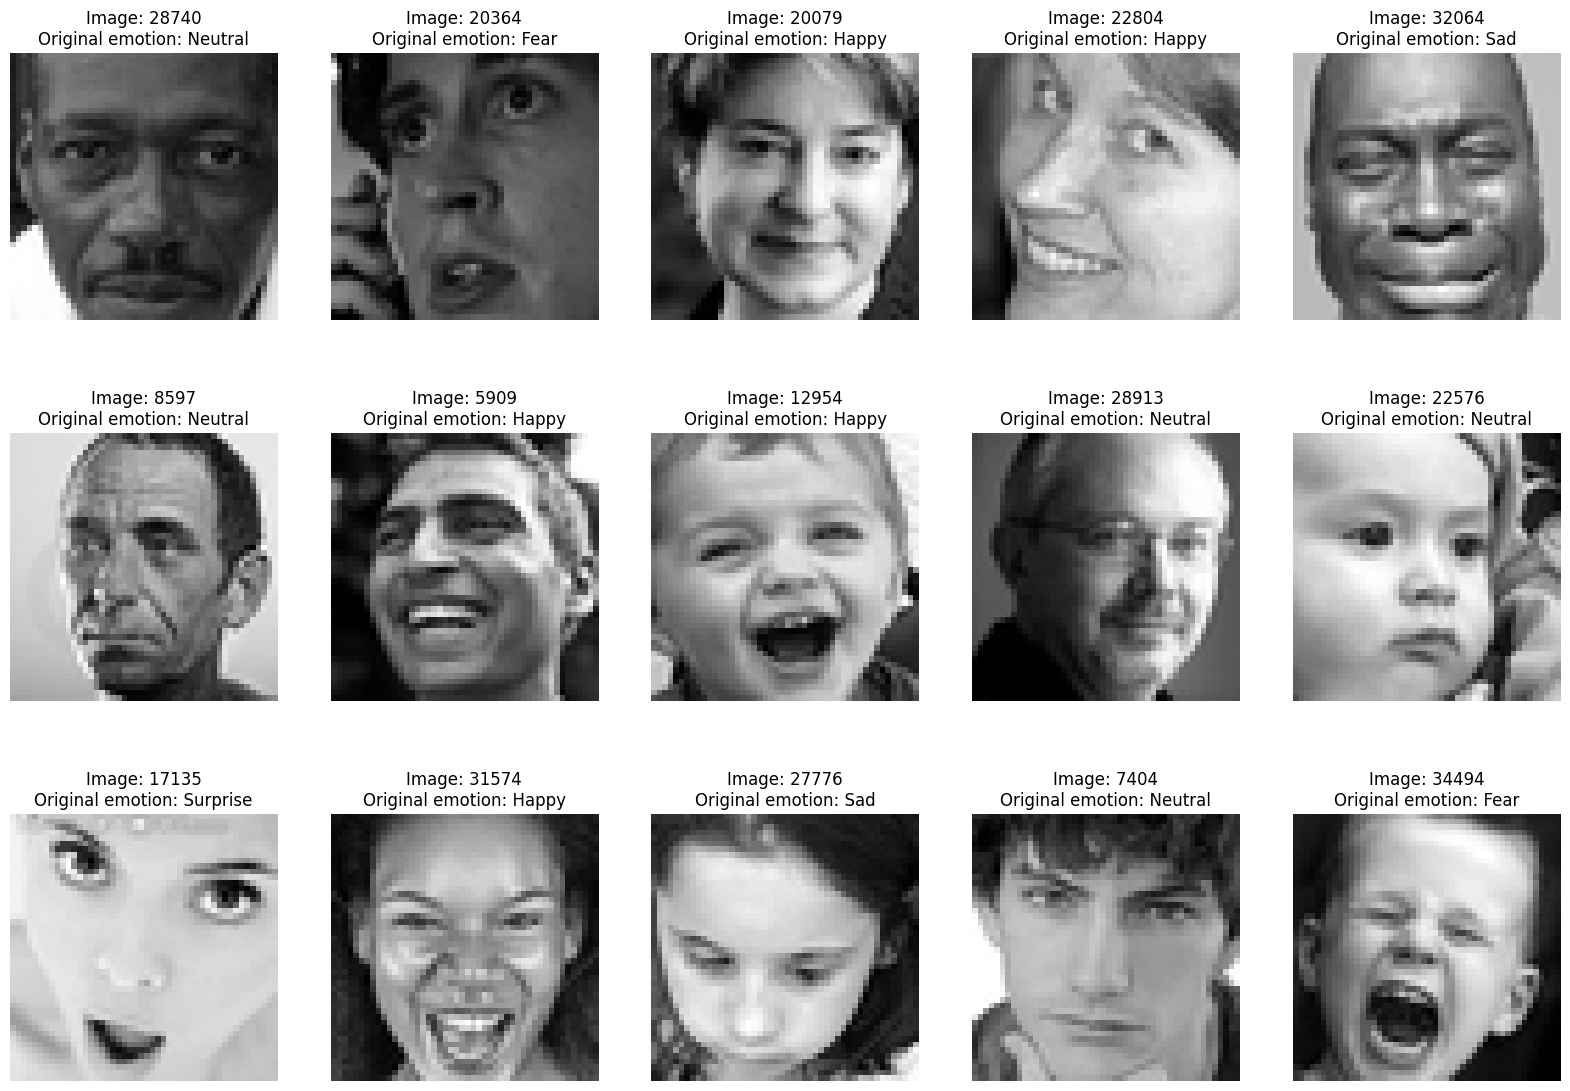

In [2]:
data = pd.read_csv("/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv")
# Split pixel values and create a new column

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)
print(data.columns)

pixels_values = data[' pixels'].apply(lambda x: list(map(int, x.split()))).tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(float)

test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
    """ 

    Function displaying 15 randomly chosen images. Arguments:
    
    imgs:  Source of images
    
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names. As a result, emotion name will be displayed above every image.
    
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names. As a result, emotion name will be displayed above image.
    
    random: Defult "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs) otherwise randomly chosen from values passed into "indices" argument without replacement.
    
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution. 
    
    """
    
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 15)
    else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        

show_random(images, emotion_nms_org= data['emotion_name'])


# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [3]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

# Building CNN

In [4]:
# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        3

# Training CNN using Data Augmentation

In [6]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping


# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


#checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=406,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    #callbacks=[early_stopping]
                             )


Epoch 1/406


/tmp/ipykernel_43/972976292.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train,
2023-12-23 18:42:24.389368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


908/908 [==============================] - 27s 17ms/step - loss: 2.0649 - accuracy: 0.2260 - val_loss: 2.5590 - val_accuracy: 0.2170
Epoch 2/406
908/908 [==============================] - 14s 16ms/step - loss: 1.8173 - accuracy: 0.2433 - val_loss: 3.7039 - val_accuracy: 0.2080
Epoch 3/406
908/908 [==============================] - 15s 16ms/step - loss: 1.8095 - accuracy: 0.2483 - val_loss: 2.9767 - val_accuracy: 0.2232
Epoch 4/406
908/908 [==============================] - 15s 16ms/step - loss: 1.7991 - accuracy: 0.2529 - val_loss: 3.1940 - val_accuracy: 0.2207
Epoch 5/406
908/908 [==============================] - 15s 16ms/step - loss: 1.7895 - accuracy: 0.2573 - val_loss: 2.6299 - val_accuracy: 0.2613
Epoch 6/406
908/908 [==============================] - 15s 16ms/step - loss: 1.7779 - accuracy: 0.2648 - val_loss: 3.7343 - val_accuracy: 0.2409
Epoch 7/406
908/908 [==============================] - 15s 16ms/step - loss: 1.7658 - accuracy: 0.2700 - val_loss: 3.4288 - val_accuracy: 0.27

# Loading download model .h5 format


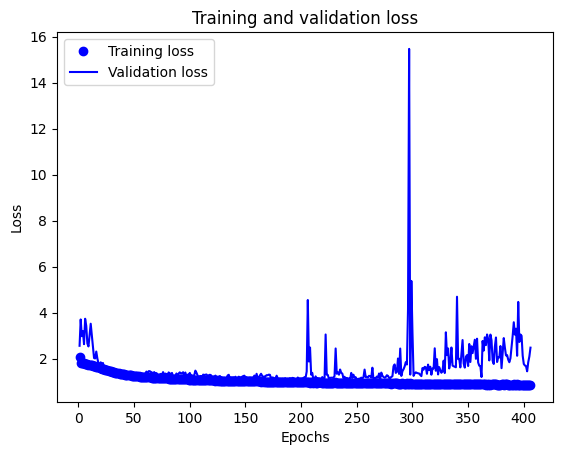

In [7]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

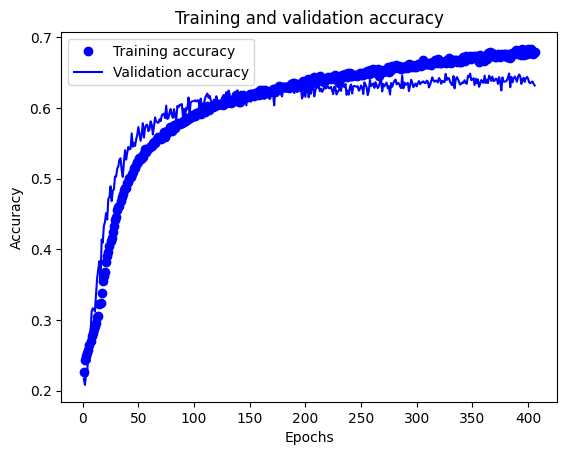

In [9]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

113/113 [==============================] - 0s 3ms/step


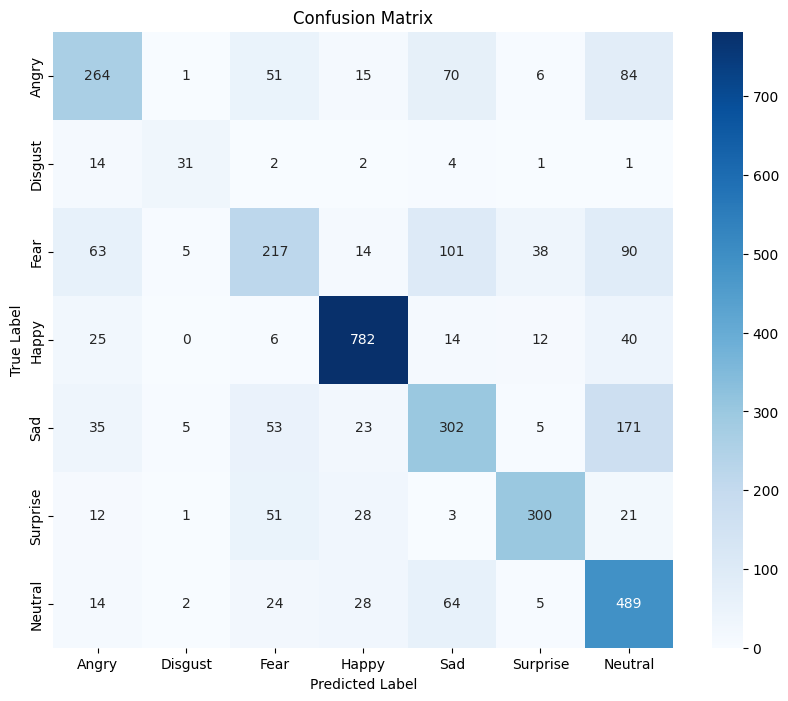

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['acc'])
    plt.plot(data['val_acc'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history)

In [ ]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)

In [10]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

In [12]:
correct, results_df = predict_classes(model, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

4/4 [==============================] - 0s 46ms/step


### Correctly predicted images

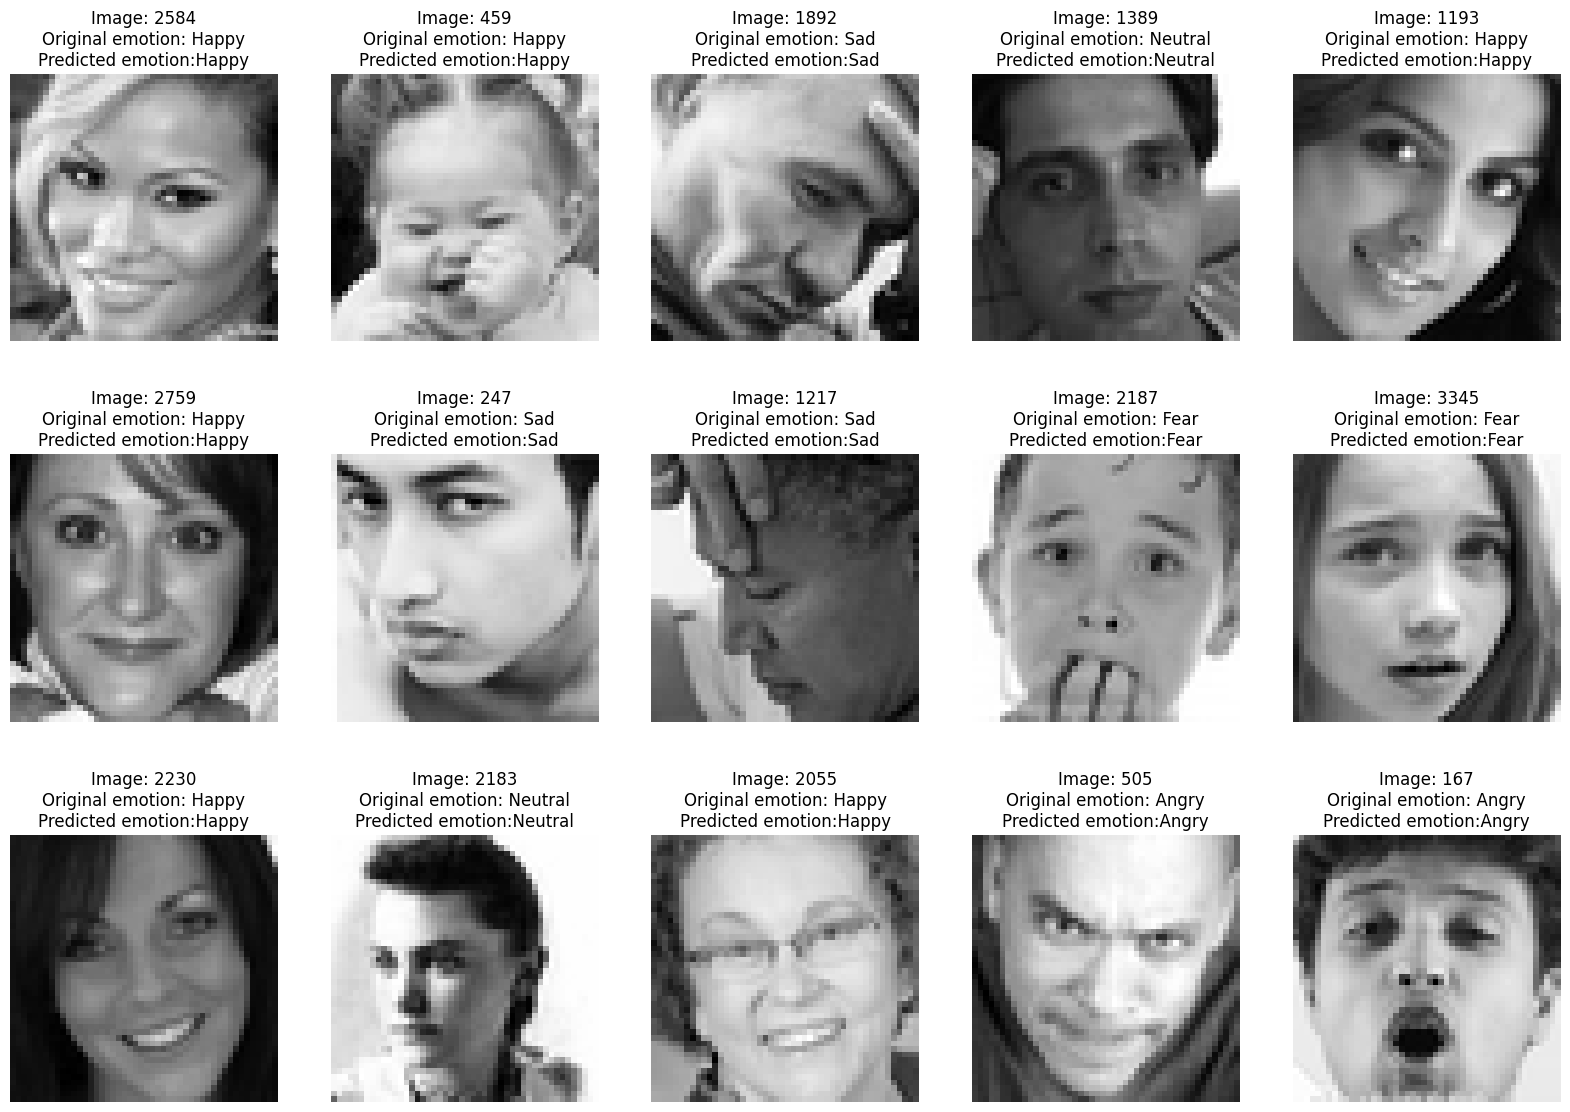

In [13]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

### Wronly predicted images

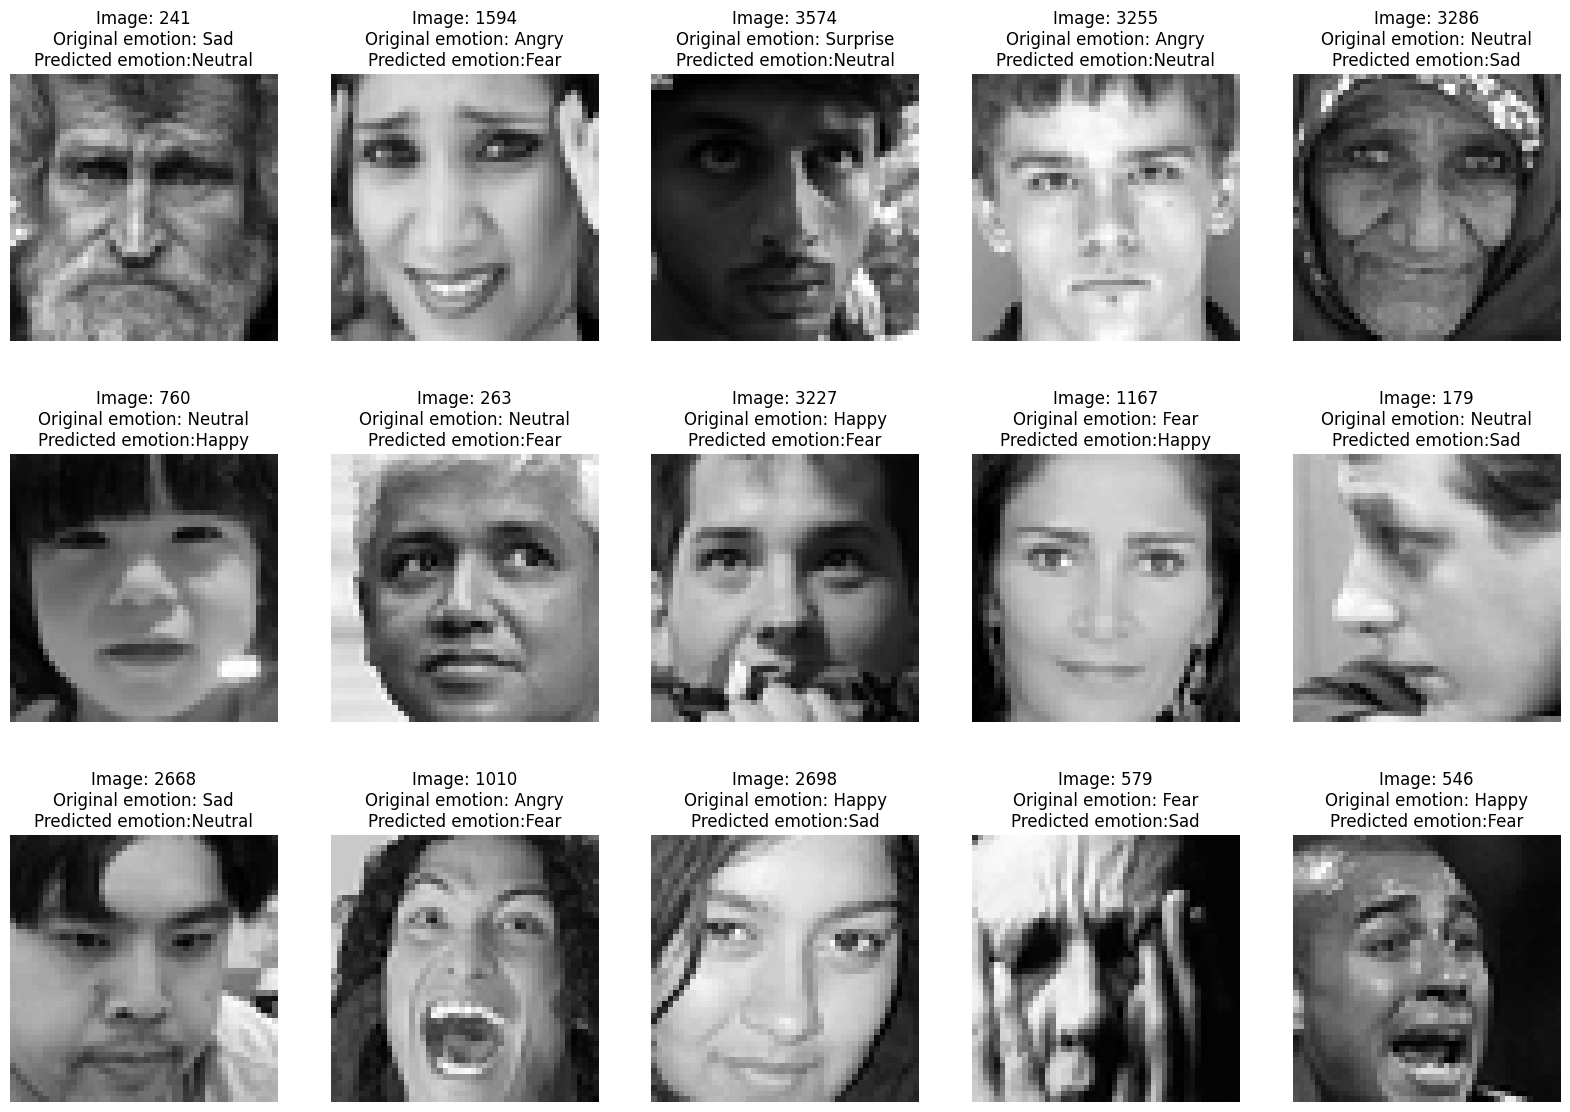

In [14]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)

### Confusion matrix

In [17]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

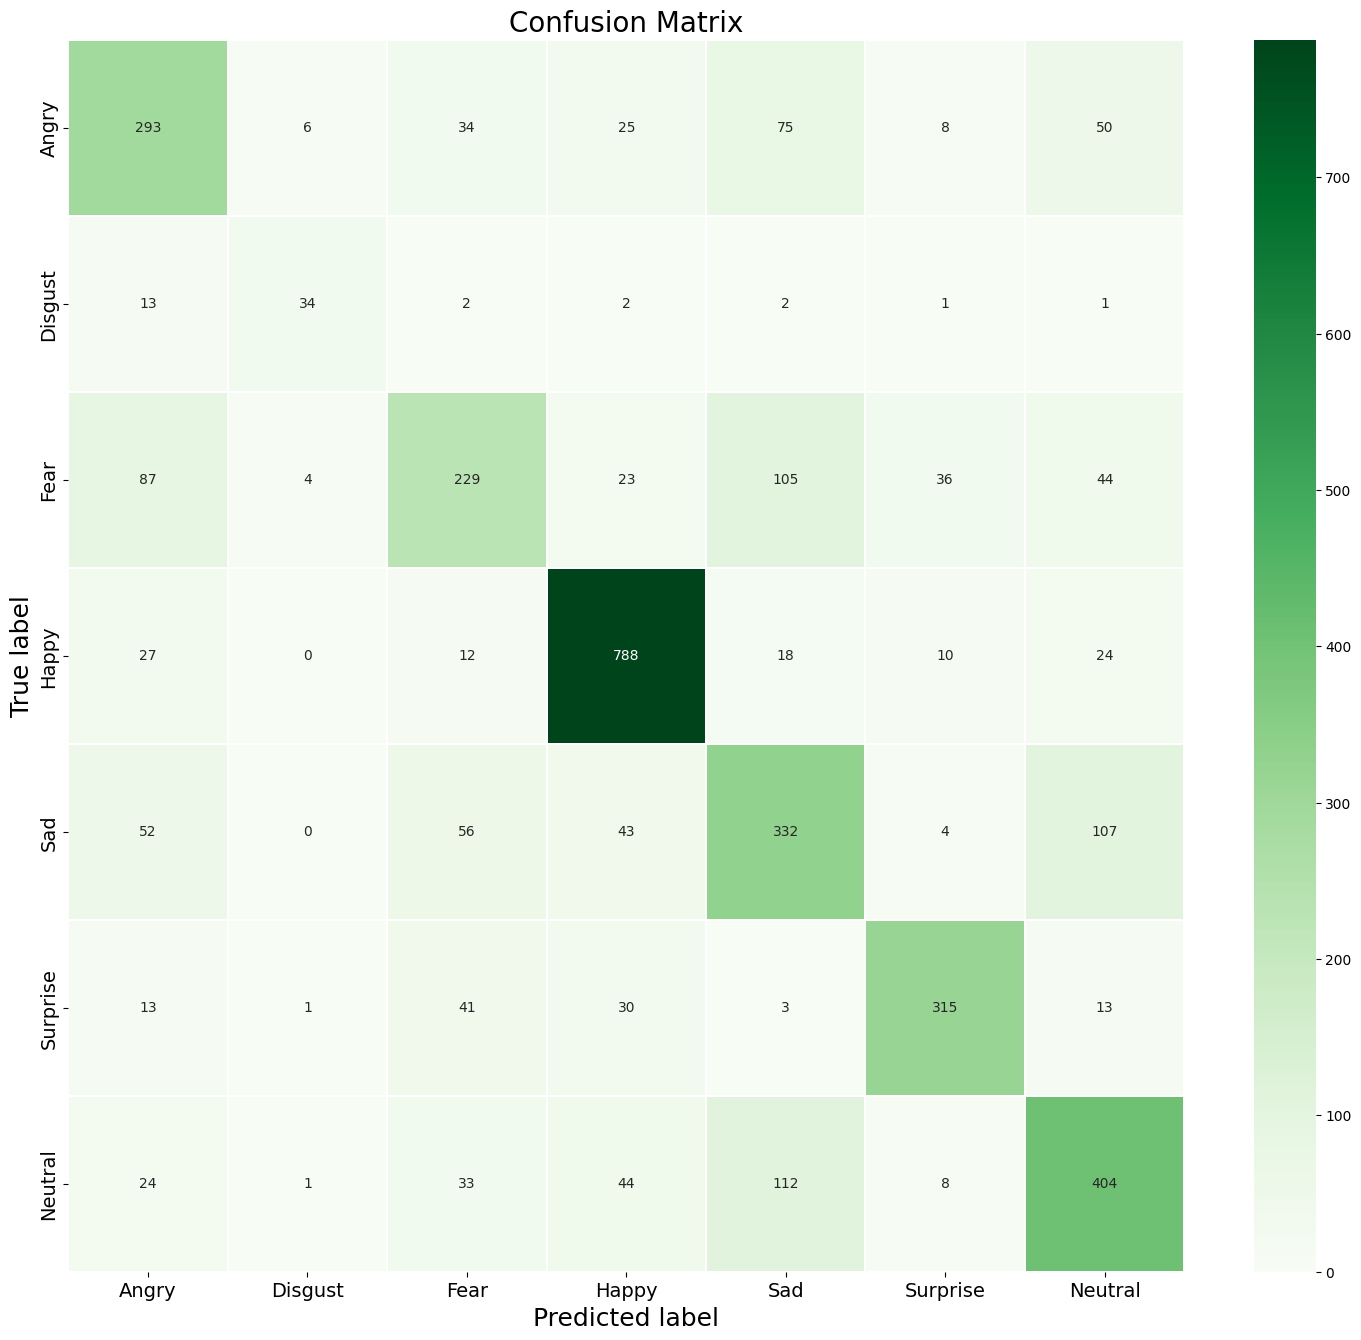

In [16]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], colour = 'Greens')

In [19]:
model.save('model_web_app.h5')
from IPython.display import FileLink

FileLink(r'model_web_app.h5')

/kaggle/working/model_web_app.h5